In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string 
import warnings 
import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split

from fastai import *
from fastai.text import *
from pathlib import Path

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
# Local mode : give the full path to location of data folder

# PATH = "/app/analyse/"

In [0]:
# Google colab mode
# Link to google drive and download data

from google.colab import drive
drive.mount('/content/gdrive/')
# then give the path where your data is stored (in google drive)
PATH = "/content/gdrive/My Drive/ssh_files/nlp"

In [0]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

In [0]:
# Check devices
from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Device 0 : b'Tesla K80'


In [0]:
torch.cuda.set_device(0)

# Data preparation

In this step, we will prepare data to be feed to ULMFIT model. 
The data should have two columns : [Targets, Text]

In [0]:
# load data from feather file
import pandas as pd

data = pd.read_feather(f'{PATH}/data/dataset_processed_balanced')

In [0]:
data.tail()

,index,text,clean_text,category
34131,126765,Lady Gaga Has Nothing On These Bizarre Marine ...,lady gaga bizarre marine worm marine zoologist...,ENVIRONMENT
34132,151131,U.S. Wildfire Interactive Shows Rising Tempera...,wildfire interactive show rise temperature sno...,ENVIRONMENT
34133,176713,Clean Energy Investment Slows Amid Uncertainty...,clean energy investment slow amid uncertainty ...,ENVIRONMENT
34134,196290,Brazil Navy: Oil Stain Spotted In Chevron Fiel...,brazil navy oil stain spot chevron field compa...,ENVIRONMENT
34135,152383,Baby Gorilla Twins Have An Adorable Playdate I...,baby gorilla twin adorable playdate rwanda vol...,ENVIRONMENT


In [0]:
# function to make text lower case
def lower(text):
    return text.lower()

In [0]:
data['text_lower'] = data['text'].apply(lower)

In [0]:
data.tail()

,index,text,clean_text,category,text_lower
34131,126765,Lady Gaga Has Nothing On These Bizarre Marine ...,lady gaga bizarre marine worm marine zoologist...,ENVIRONMENT,lady gaga has nothing on these bizarre marine ...
34132,151131,U.S. Wildfire Interactive Shows Rising Tempera...,wildfire interactive show rise temperature sno...,ENVIRONMENT,u.s. wildfire interactive shows rising tempera...
34133,176713,Clean Energy Investment Slows Amid Uncertainty...,clean energy investment slow amid uncertainty ...,ENVIRONMENT,clean energy investment slows amid uncertainty...
34134,196290,Brazil Navy: Oil Stain Spotted In Chevron Fiel...,brazil navy oil stain spot chevron field compa...,ENVIRONMENT,brazil navy: oil stain spotted in chevron fiel...
34135,152383,Baby Gorilla Twins Have An Adorable Playdate I...,baby gorilla twin adorable playdate rwanda vol...,ENVIRONMENT,baby gorilla twins have an adorable playdate i...


Now we split the data into a training and testing sets. For info, the training dataset will be then split into training and validation sets (this is done inside fast.ai library). 
The test set will not be used until the end of training/finetuning. 

In [0]:
# Split data
xtrain, xtest, ytrain, ytest = train_test_split(data['text_lower'], data.category, random_state=42,test_size=0.1)

Prepare data for Fast.ai model. First column is target and second is text

In [0]:
data_train = pd.DataFrame([ytrain, xtrain]).T

In [0]:
data_train.head()

,category,text_lower
30967,DIVORCE,who gets the family dog after divorce? do you ...
19410,PARENTS,"dog lets baby climb all over him, continues be..."
8211,COMEDY,here's what you missed if you weren't at the 1...
18127,EDUCATION,hosting an exchange student expands your world
27889,FIFTY,the alarming phone call i got from my daughter...


In [0]:
data_train.shape

(30722, 2)

We can save this data for now, so it can be re-used later. 

In [0]:
data_train.to_csv(f'{PATH}/data/train_ulmfit_balanced.csv', index=False, header=False)

Now we load the data for language model finetuning. `TextLMDataBunch` does a lot of preprocessing under the hood (toknenization using SpaCy and keeping 60,000 most commom tokens for example, default batch size of 64). 
Take a look at the documentation https://docs.fast.ai/text.data.html#TextLMDataBunch  

In [0]:
data_lm = TextLMDataBunch.from_csv(f'{PATH}/data/', 'train_ulmfit_balanced.csv', min_freq=1)

In [0]:
data_lm.show_batch()

idx,text
0,tropes is a good starting point . xxbos here are the biggest companies by revenue in each state xxbos donald trump caps off 2016 by winning time 's person of the year its difficult to deny his incredible impact on the news this year for better or worse . xxbos the world bank accidentally left me a voicemail discussing their strategy to downplay rights abuses on june 27 we released
1,". "" xxbos zoe saldana questions why white actors have played characters of color for decades xxbos move - up or remodel ? how do you decide ? making this decision requires a lot of number - crunching . bringing in a contractor to advise you on the cost of your potential remodel and working with a realtor on a potential sale will give you the data you need to"
2,"a wonderful place to raise a family . so that 's what we did . now we 're leaving . xxbos kristen stewart 's year in sheer , short and cropped outfits ( photos ) we 've seen a lot of the actress in 2012 . xxbos from couch to tough mudder workout these moves will target areas of the body needed to hurdle , crouch , lunge and jump"
3,"- love couples ? we think not , especially when it comes xxbos police officer quietly buys food at chipotle for man in need the humble sergeant thought nobody would know about the kind act . xxbos last stop -- the grand canyon should n't the grand canyon be considered sacred by all americans ? do we want to risk contaminating it for what amounts to forever -- just so"
4,"wine "" or "" brown bag vino . "" but the cultured call it "" fortified wine . "" xxbos ex - mlb prospect cut by team after video of him beating girlfriend surfaces "" there is no choice but to sever the relationship , "" the team manager said after seeing the footage . xxbos people on twitter prepare for trump 's second year with # trumpmoviesequels the sequels"


# Step1: Fine-tuning the language model

ULMFit (https://arxiv.org/abs/1801.06146) suggests to use transfer learning for language models. Using a language model initializaed by weights of a pretrained model on Wikitext 103 (https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/).

`language_model_learner` is used to load the pretrained model `AWD_LSTM` and initialize the model based on language model data `data_lm`. 

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [0]:
#The architecture can be seen as follows
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(37824, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(37824, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=37824, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


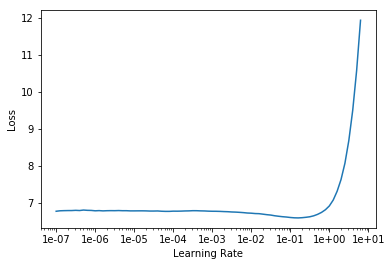

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
# Train freezed model
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.719793,5.228250,0.207189,01:56


In [0]:
# Train the unfreezed model
learn.unfreeze()
learn.fit_one_cycle(3, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,5.201439,5.054091,0.219461,02:16
1,4.978153,4.988992,0.225725,02:16
2,4.794578,4.983326,0.226841,02:16


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc_balanced')

# Step2 - Training the classifier

Now we have trained the language model following the steps explained in ULMFit paper and saved the encoder weights. We can train a classifier while re-using the encoder weights.

In [0]:
# classifier

# Prepare data for classifier
data_clas = TextClasDataBunch.from_csv(f'{PATH}/data/', 'train_ulmfit_balanced.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)

data_clas.save('train_ulmfit_balanced_TextClas')

In [0]:
data_clas.show_batch()

text,target
"xxbos sunday roundup this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in u.s . history , as donald trump "" humbly "" accepted the republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" america . it capped a week of nightly disarray - with",POLITICS
"xxbos my vassar college commencement speech for the class of 2015 as someone who runs a 24 / 7 digital media company and who uses every form of social media ever invented , i hope i have some street cred when i urge those of you graduating this year to build boundaries , introduce digital detoxes into your life , learn to regularly disconnect from the jumble and the cacophony",EDUCATION
"xxbos the final solution : a thanksgiving message ( or ai n't too proud to hate ) a friend writes , "" i have been thinking about your recent posts and i have to say i agree about republicans . i ca n't look them in the eye , any of 'em , but especially those who voted for trump . i have always considered myself a fairly rigid and",COMEDY
"xxbos i 'm going to keep smiling there are countless small differences between where i grew up ( michigan ) and where i now live ( philadelphia ) that i had to learn in order to fit in . i no longer say "" downtown . "" instead , it 's "" center city . "" i do n't go "" to the beach . "" i go "" down",FIFTY
xxbos the surprising thing a nurse told me to drink for my health in the mid - eighties the company i worked for decided they wanted to keep their employees in tip - top condition . with that in mind they built a fitness center right in our building . there were treadmills and free - weights all designed to keep us from dropping dead at our desks . the,FIFTY


Define the text classifier and load the encoder weights.

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.7)
learn.load_encoder(f'{PATH}/data/models/ft_enc_balanced')
learn.freeze()

In [0]:
# Specify the metrics we want to follow
metrics = [accuracy, FBeta('macro')]
learn.metrics = metrics 

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.94E-03
Min loss divided by 10: 2.51E-02


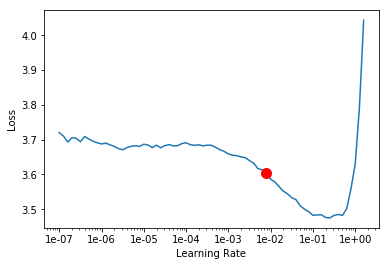

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
# Train last layer

learn.fit_one_cycle(cyc_len=1, max_lr=min_grad_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.344797,1.913160,0.442636,0.438015,00:59


In [0]:
# Train -2 layers 

learn.freeze_to(-2)
learn.fit_one_cycle(1, max_lr=1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.298214,1.827662,0.458259,0.453020,01:08


In [0]:
# Train -3 layers 

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.110512,1.732716,0.486737,0.483294,01:44


In [0]:
# Train unfreezed model

learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.031039,1.682249,0.502197,0.495227,02:22
1,2.003210,1.691242,0.509194,0.500235,02:22
2,1.862261,1.644109,0.534093,0.529786,02:21
3,1.700987,1.573936,0.558666,0.554075,02:22
4,1.436794,1.530727,0.569406,0.565571,02:22
5,1.218361,1.482256,0.581448,0.581475,02:22
6,1.030225,1.517380,0.595281,0.594180,02:22
7,0.833658,1.540598,0.598861,0.598815,02:21
8,0.732878,1.581787,0.600000,0.599413,02:21
9,0.656480,1.574146,0.601465,0.600860,02:22


In [0]:
# Save weights.

learn.save("trained_ulmfit_balanced")

In [0]:
# Reload the model from scratch and re-use the saved weights 

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)

In [0]:
learn.load(f'{PATH}/data/models/trained_ulmfit_balanced')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (24576 items)
x: TextList
xxbos why it 's impossible to ' fail ' at retiring abroad over our years of living abroad , we 've talked to more than a few people who have a secret fear . it 's a fear shared by people just beginning to think about retiring or working abroad and by folks who have already made the move . the secret fear is this ... what if i fail ?,xxbos walmart accused of gift receipt scam for 2nd year in a row a request for comment from walmart via email was not immediately returned . however , back in 2011 , walmart spokesperson lorenzo,xxbos switching from a college to a university could mean more money , more students even dropping the word " state " could bring more money for school .,xxbos three pairs of shoes i once read that people in third world countries believe that anyone who has three pairs of shoes is affluent . how many pairs of shoes do you have ?,xxbos when a dream wedding in hawaii is n't all it 's cracke

# Predictions and evaluation

Evaluation on the validation dataset. 

In [0]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,86,3,0,3,0,0,4,4,0,0,0,2,0,2,3,1,2,5,0,0,1,3,2,1,1,3,1,4,0,1,0,2,0,1
1,5,98,3,0,7,1,9,13,0,1,0,2,1,0,0,2,5,1,0,0,2,1,3,1,4,3,1,0,0,0,0,5,0,1
2,1,0,84,1,0,1,0,0,3,0,2,6,4,4,0,9,0,4,20,1,4,2,0,2,1,0,8,1,0,1,1,6,1,2
3,7,4,0,94,0,0,3,12,0,2,0,3,1,4,1,0,6,7,1,3,4,1,0,0,7,3,4,2,0,11,0,4,2,1
4,3,20,3,1,131,0,4,2,0,0,0,2,2,0,0,2,3,2,2,0,3,1,1,0,4,1,0,0,0,17,0,2,1,4
5,0,1,0,1,0,164,0,0,0,4,0,0,0,2,0,0,1,0,2,6,0,0,0,0,0,0,0,1,13,1,2,5,0,0
6,1,7,3,1,4,0,134,0,1,3,0,2,0,2,0,10,5,4,6,10,4,1,0,2,4,1,2,0,0,0,1,3,1,0
7,8,22,3,22,0,0,1,91,1,1,1,2,0,1,0,3,8,3,0,1,2,6,2,1,7,4,4,0,0,4,0,6,3,1
8,1,0,2,3,2,0,0,0,107,0,2,4,24,0,2,0,0,0,1,4,2,0,0,7,2,0,3,4,0,0,4,0,4,1


In [0]:
from sklearn.metrics import classification_report

pred = predictions.data.numpy()
t = targets.data.numpy()
print(classification_report(t, pred))

              precision    recall  f1-score   support

           0       0.64      0.49      0.55       176
           1       0.58      0.49      0.53       201
           2       0.50      0.44      0.47       190
           3       0.50      0.46      0.48       204
           4       0.62      0.71      0.66       184
           5       0.81      0.82      0.81       200
           6       0.63      0.69      0.66       193
           7       0.44      0.58      0.50       158
           8       0.60      0.64      0.62       168
           9       0.59      0.51      0.54       180
          10       0.73      0.78      0.75       169
          11       0.58      0.45      0.51       193
          12       0.51      0.56      0.54       200
          13       0.39      0.46      0.42       168
          14       0.77      0.85      0.81       170
          15       0.46      0.40      0.43       174
          16       0.83      0.65      0.73       186
          17       0.63    

Evaluation on the testing dataset. 

In [0]:
# Add test dataset to the model
learn.data.add_test(list(xtest))

# Do inference 
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
pred = preds.argmax(1).data.numpy()
y_t = [learn.data.c2i[i] for i in list(ytest)]
print(classification_report(y_t, pred))

              precision    recall  f1-score   support

           0       0.55      0.67      0.60        87
           1       0.58      0.45      0.51        93
           2       0.38      0.42      0.40        98
           3       0.54      0.45      0.49        99
           4       0.61      0.59      0.60        91
           5       0.70      0.76      0.73       100
           6       0.60      0.70      0.65       105
           7       0.65      0.44      0.52       112
           8       0.68      0.47      0.56        93
           9       0.36      0.45      0.40        85
          10       0.65      0.78      0.71        89
          11       0.60      0.62      0.61       100
          12       0.47      0.42      0.44       100
          13       0.35      0.39      0.37       109
          14       0.74      0.82      0.78        98
          15       0.26      0.45      0.33        94
          16       0.83      0.60      0.70        95
          17       0.61    

# Exporting the model

In [0]:
learn.export('exported_model_balanced')

In [0]:
# Example of inference

from random import sample
i=sample(list(xtest.index), 1)[0]
sentence = xtest[i]
print(sentence)
print('prediction:', learn.predict(sentence)[0])
print('true value:', ytest[i])

look: everything you need to know to beat stress and boost happiness 
prediction: HEALTHY LIVING
true value: HEALTHY LIVING


Finally, let us save the test data as inference data for later inference usage.

In [0]:
data_inference = pd.DataFrame([ytest, xtest]).T

data_inference = data_inference.reset_index()
data_inference.to_feather(f'{PATH}/data/dataset_inference_balanced')

# Inference on CPU


In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [0]:
path = "/content/gdrive/My Drive/ssh_files/nlp/data"

In [0]:
# Specify device CPU
defaults.device = torch.device('cpu')

In [0]:
# Load trained model
learn = load_learner(path, 'exported_model_balanced')

In [0]:
import pandas as pd
# load data from feather file
data = pd.read_feather(f'{path}/dataset_inference_balanced')

In [0]:
%%time
from random import sample

# Clean ASCI 
def clean_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

i=sample(list(data.index), 1)[0]
sentence = data['text'][i]
print(sentence)
print('prediction:', learn.predict(clean_ascii(sentence.lower()))[0])
print('real class:', data['category'][i])

CIA Divorces: The Secrecy When Spies Split The Fredericksburg woman divorcing her husband laid out all the messy details, including the most secret of them all. Her
prediction: DIVORCE
real class: DIVORCE
CPU times: user 154 ms, sys: 3.35 ms, total: 157 ms
Wall time: 157 ms
